In [1]:
'''
From the book 'Hands-on Machine Learning with Scikit-Learn and TensorFlow'
by A. Géron
Chapter 3
'''

from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


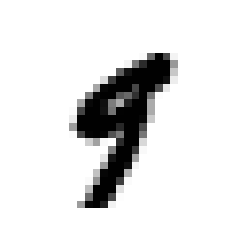

9


In [23]:
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
          interpolation="nearest")
plt.axis('off')
plt.show()
print(y[36000])

In [3]:
#The dataset is already split between training and test, let's save it
y = y.astype(int) #It was considered as a string
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [4]:
#Shuffling the training set, to be sure that the cross validation sets 
#are homogenous
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [5]:
#Training a binary classifier
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [6]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit])

array([False])

In [7]:
#Implementing Cross-Validation yourself
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95675
0.9658
0.92955


In [8]:
#Cross-validation built-in function
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

'''
95% accuracy seems very good, except that roughly 90% of the dataset is not a 5,
so it doesn't mean anything.
Generally accuracy is not the preferred performance measure for classifiers,
especially when dealing with skewed datasets.
'''

"\n95% accuracy seems very good, except that roughly 90% of the dataset is not a 5,\nso it doesn't mean anything.\nGenerally accuracy is not the preferred performance measure for classifiers,\nespecially when dealing with skewed datasets.\n"

In [9]:
#Implementing a Confusion Matrix (display the number of times a value
#is confused with another). Indicates true positives and false positives
#Row = actual class
#Column = predicted class

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53974,   605],
       [ 1652,  3769]], dtype=int64)

In [10]:
'''
precision = TP / (TP + FP)
TP: True Positive.  FP: False Positive.    FN: False Negative

Recall = TP / (TP + FN)
also called sensitivity or true positive rate
'''
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8616826703246456
0.6952591772735658


In [11]:
'''
F_1: harmonic mean, a single metric to compare two classifiers
F_1 = 2(precision*recall / (precision + recall))
The classifier will only get a high F_1 score if both recall and precision are 
high

Depending on the case, you might want high precision more than high recall,
or the other way around
Precision/recall tradeoff: increasing precision reduces recall and vice versa
'''
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7695763144461462

In [12]:
#Setting up your own decision threshold
#Use the decision function instead of predict() and apply the threshold you want

y_scores = sgd_clf.decision_function([some_digit])
threshold = 500 #set the number you want
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


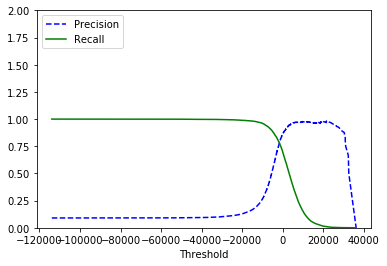

In [13]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method='decision_function')

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0, 2])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [14]:
print(y_scores[y_scores > 1])

[6317.57683719 4217.01941877 3799.33857291 ... 4119.35304882  354.10922136
 4549.00372944]


Text(0, 0.5, 'Precision')

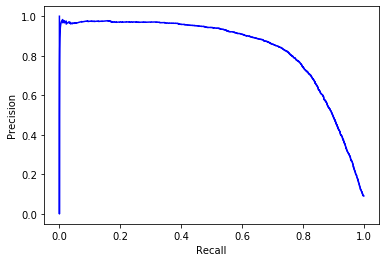

In [15]:
plt.plot(recalls, precisions, 'b')
plt.xlabel('Recall')
plt.ylabel('Precision')

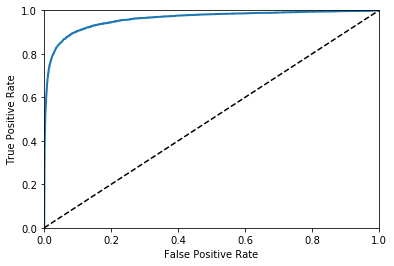

0.9606428485023185


In [17]:
#ROC curve (receiver operating characteristic)
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()
'''The higher the recall (TPR), the more false positives (FPR) the 
classifier produces.

The dotted line corresponds to a purely random classifier. Your classifier
needs to stay away from that line

One way to compare classifiers is to measure the area under the curve (AUC)
A perfect classifier has a ROC AUC of 1, a purely random one has a ROC AUC of
0.5

'''
'''
Since the ROC curve is so similar to the precision/recall (or PR)
curve, you may wonder how to decide which one to use. As a rule
of thumb, you should prefer the PR curve whenever the positive
class is rare or when you care more about the false positives than
the false negatives, and the ROC curve otherwise. For example,
looking at the previous ROC curve (and the ROC AUC score), you
may think that the classifier is really good. But this is mostly
because there are few positives (5s) compared to the negatives
(non-5s). In contrast, the PR curve makes it clear that the classifier
has room for improvement (the curve could be closer to the topright
corner).
'''
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train_5, y_scores))

<ipython-input-18-07e019d415b8>:12: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(loc="bottom right")


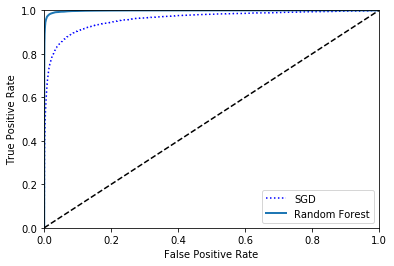

In [18]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method='predict_proba')
#We need scores, not probabilities
y_scores_forest = y_probas_forest[:, 1] #score = proba of positive class
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

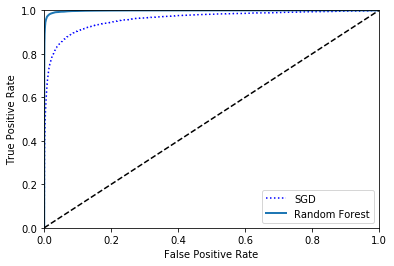

In [19]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [21]:
#Training a model able to recognize all numbers

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3])

In [24]:
#Checking how the decision was made

some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)

[[-36175.74389263 -27808.06258302 -17662.92979606   1246.416875
   -1855.33138755  -2568.24083562 -36463.95764351  -8381.97415665
   -3049.3319119  -10353.29729109]]


In [25]:
#With a random forest classifier
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])
print(forest_clf.predict([some_digit]))

print(forest_clf.predict_proba([some_digit]))

[9]
[[0.01 0.   0.   0.   0.09 0.   0.   0.02 0.   0.88]]


In [26]:
#Cross validation of the full classifier, accuracy
from sklearn.preprocessing import StandardScaler

print('Value before scaling:\t',
      cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring ='accuracy'))

#scaling the inputs increases accuracy
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
print('Value after scaling:\t',
     cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy'))

Value before scaling:	 [0.8897 0.8699 0.8526]


c:\users\sydney\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:554: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


Value after scaling:	 [0.9     0.89855 0.9036 ]


c:\users\sydney\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:554: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


c:\users\sydney\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:554: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
c:\users\sydney\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:554: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


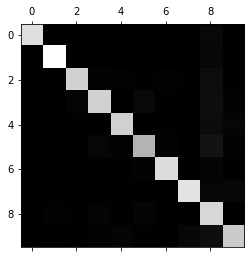

In [27]:
#Error analysis

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show() #plot of the confusion matrix

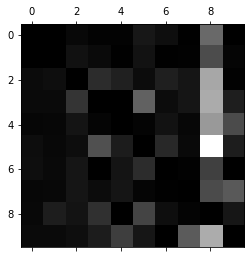

In [28]:
#Comparing error rates
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0) #putting 0 on the diagonal to be able
#to focus easily only on the errors
#whiter areas mean that there is more confusion there
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

#Once you have noticed what is wrong thanks to the matrix,
#improve the classification

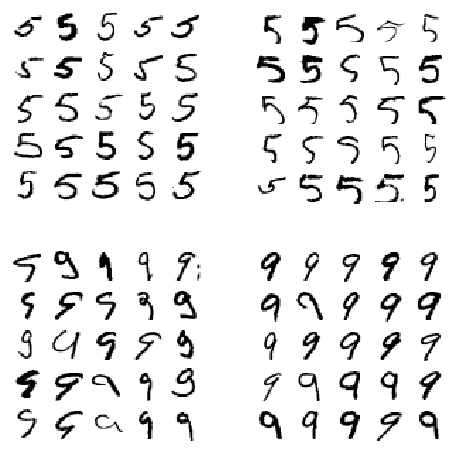

In [30]:
#Looking at errors individually
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")


cl_a, cl_b = 5, 9
X_aa = X_train[(y_train ==cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train ==cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train ==cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train ==cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

'''
As we can see, this model has more difficulty recognizing a '5', it will
sometime say it is a '8'
Below are displaye only a few misclassification, which are not representative
of the entire values msiclassified.
For example, we can see some '9' (bottom left) looking like '4', but they
are more often classified as '8' and this is not visible from this sample
'''

In [31]:
#Multilabel Classification => can output multiple labels at a time
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7) #test if > 7
y_train_odd = (y_train %2 == 1) #test if odd number
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

print(knn_clf.predict([some_digit]))

[[ True  True]]


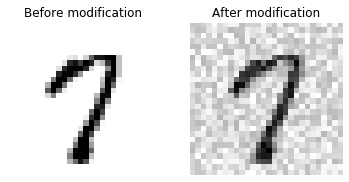

In [41]:
#Multioutput Classification


noise = np.random.randint(0, 100, (len(X_train), 784))
noise_test = np.random.randint(0, 100, (len(X_test), 784))
X_train_mod = X_train + noise
X_test_mod = X_test + noise_test
y_train_mod = X_train
y_test_mod = X_test

#plotting an example
ex = X_train[42]
ex_mod = X_train_mod[42]

ex_image = ex.reshape(28, 28)
ex_mod_image = ex_mod.reshape(28, 28)

plt.subplot(1, 2, 1)
plt.imshow(ex_image, cmap = matplotlib.cm.binary,
          interpolation="nearest")
plt.title('Before modification')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ex_mod_image, cmap = matplotlib.cm.binary,
          interpolation="nearest")
plt.title('After modification')

plt.axis('off')
plt.show()

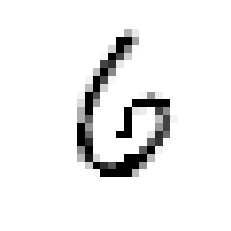

In [43]:
#Making a classifier removing the noise
some_index = 123
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digits(clean_digit)

In [44]:
#Exercises
'''
1. Try to build a classifier for the MNIST dataset that achieves over 97% 
accuracy on the test set. Hint: the KNeighborsClassifier works quite well for
this task; you just need to find good hyperparameter values (try a grid search
on the weights and n_neighbors hyperparameters).

Steps:
data preparation: OK
Test several models and keep the most promising ones: OK, KNeightborsClassifier
Fine tuning with grid search:
Verify on the test data:
'''
#First, let's see how a basic knn classifier performs:
my_knn_clf = KNeighborsClassifier()

cross_val_score(my_knn_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')
#We are using the scaled inputs @optimize what you can

array([0.9436 , 0.94215, 0.942  ])

In [ ]:
#Now that we have a point of reference, let's perfom a grid search on the 
#training set
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy

param = 
    [{'weights': ['uniform', 'distance'],'n_neighbors': [3, 4, 5]}]   
        
         
grid_search = GridSearchCV(my_knn_clf, param, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print('Best param \t', grid_search.best_params_)
print('Best accuracy \t', grid_search.best_score_)
#By default, the best model will be kept in memory

if grid_search.best_score_ > 0.97:
    y_pred = grid_search.predict(X_test_scaled)
    print(accuracy_score(y_test, y_pred))
    if precision_score(y_test, y_pred) >= 0.97:
        print('GG')
else:
    print('Too bad')